In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import env

from sklearn.model_selection import train_test_split

import sklearn.preprocessing

## Acquire Stage

In [2]:
# connection function for accessing mysql 
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

query = """
select * 
from properties_2017
join predictions_2017 using(parcelid)
where transactiondate between "2017-05-01" and "2017-06-30";
"""

df = pd.read_sql(query, get_connection('zillow'))
df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,11393337,2463969,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,43439.0,2016.0,22755.0,756.94,Y,14.0,6.037235e+13,117,0.086137,2017-06-08
1,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
2,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30
3,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,None,NaN,6.059064e+13,2028,0.021085,2017-06-01
4,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,None,NaN,6.037703e+13,3273,-0.325393,2017-06-01


In [3]:
df.shape

(21943, 62)

## Let's do a little prep on this Zillow data

In [4]:
# Some prep
df = df.rename(columns={"bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "calculatedfinishedsquarefeet": "square_feet", "taxamount": "taxes", "taxvaluedollarcnt": "tax_value"})

In [5]:
features = [
    "parcelid",
    "bedrooms",
    "bathrooms",
    "square_feet",
    "tax_value"
]

df = df[features]
df = df.set_index("parcelid")
df.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11393337,3.0,3.0,1534.0,43439.0
11289917,3.0,2.0,1458.0,136104.0
11705026,2.0,1.0,1421.0,35606.0
14269464,4.0,3.0,2541.0,880456.0
11389003,3.0,2.0,1650.0,614000.0


In [6]:
# how many records do we have?
df.shape

(21943, 4)

In [7]:
# how many nulls do I have?
df.isna().sum()

bedrooms        6
bathrooms       6
square_feet    61
tax_value       6
dtype: int64

In [8]:
# Let's drop the nulls
df = df.dropna()
df.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11393337,3.0,3.0,1534.0,43439.0
11289917,3.0,2.0,1458.0,136104.0
11705026,2.0,1.0,1421.0,35606.0
14269464,4.0,3.0,2541.0,880456.0
11389003,3.0,2.0,1650.0,614000.0


In [9]:
def split_data(df, stratify_by=""):
    '''
    take in a DataFrame and return train, validate, and test DataFrames.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [10]:
train, validate, test = split_data(df, stratify_by="tax_value")

In [11]:
train.head()

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11834559,2.0,1.0,652.0,26038.0
14090662,3.0,1.5,1120.0,189649.0
11322593,3.0,2.0,2222.0,376790.0
10983576,4.0,3.0,1661.0,264420.0
11048674,3.0,2.0,1252.0,52552.0


<AxesSubplot:>

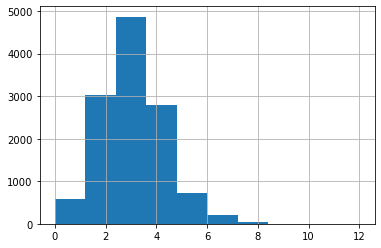

In [12]:
train.bedrooms.hist()

<AxesSubplot:>

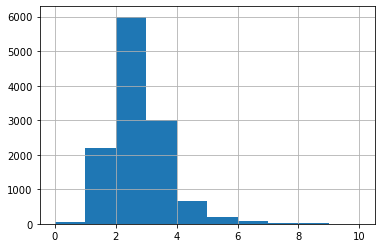

In [13]:
train.bathrooms.hist()

<AxesSubplot:>

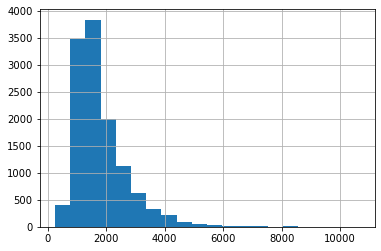

In [14]:
train.square_feet.hist(bins=20)

<AxesSubplot:>

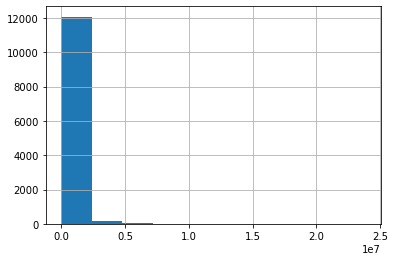

In [15]:
train.tax_value.hist()

In [16]:
train.tax_value.min()

10504.0

In [17]:
train.tax_value.max()

23858374.0

## Ok.. Scaling... Now What?
- Do the 3 Step sklearn API
    1. Make the thing (Make a scaler object
    2. Fit the thing (on the train data)
    3. Use the thing


In [18]:
# Make the thing
scaler = sklearn.preprocessing.MinMaxScaler()

In [19]:
# We fit on the training data
# in a way, we treat our scalers like our ML models
# we only .fit on the training data
scaler.fit(train)

MinMaxScaler()

In [20]:
train_scaled = scaler.transform(train)
validate_scaled = scaler.transform(validate)
test_scaled = scaler.transform(test)

In [21]:
train_scaled[0:5]

array([[0.16666667, 0.1       , 0.03937008, 0.00065138],
       [0.25      , 0.15      , 0.08430958, 0.00751199],
       [0.25      , 0.2       , 0.19012867, 0.01535928],
       [0.33333333, 0.3       , 0.13625888, 0.01064732],
       [0.25      , 0.2       , 0.09698483, 0.00176318]])

In [22]:
# turn the numpy arrays into dataframes
train_scaled = pd.DataFrame(train_scaled, columns=train.columns)
validate_scaled = pd.DataFrame(validate_scaled, columns=train.columns)
test_scaled = pd.DataFrame(test_scaled, columns=train.columns)

In [23]:
train_scaled.head()

,bedrooms,bathrooms,square_feet,tax_value
0,0.166667,0.10,0.039370,0.000651
1,0.250000,0.15,0.084310,0.007512
2,0.250000,0.20,0.190129,0.015359
3,0.333333,0.30,0.136259,0.010647
4,0.250000,0.20,0.096985,0.001763


<AxesSubplot:>

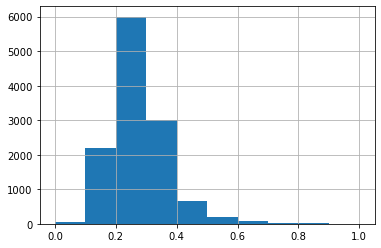

In [24]:
train_scaled.bathrooms.hist()

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

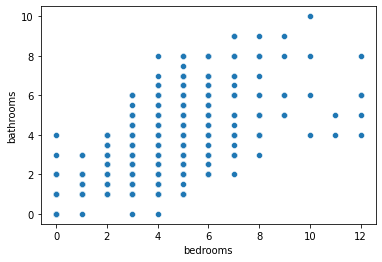

In [25]:
sns.scatterplot(x="bedrooms", y="bathrooms", data=train)

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

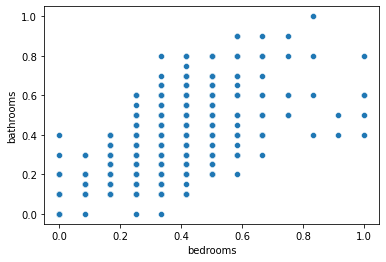

In [26]:
sns.scatterplot(x="bedrooms", y="bathrooms", data=train_scaled)

## For an MVP / 1st Draft
- Scale our continous values
- press forward

### For a second draft
- handle some outliers
- then scale
- press forward


- if we have any clear reason to use a non-linear scaler, do so...

<AxesSubplot:>

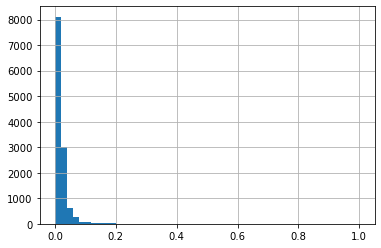

In [27]:
train_scaled.tax_value.hist(bins=50)

In [28]:
train.tax_value.sort_values(ascending=False).head(30)

parcelid
11638822    23858374.0
13895633    11317682.0
11679292     9120827.0
11593948     8946027.0
11658943     8387524.0
11679205     8248250.0
11513448     8000000.0
11889295     7766509.0
12075180     7192686.0
13895592     6878585.0
11611536     6852937.0
11641808     6771406.0
14323959     6711476.0
11684160     6523867.0
11621658     6497600.0
11638557     6435575.0
11639693     6418436.0
11680016     6396074.0
12702861     6154034.0
12031310     5740519.0
12687281     5731683.0
11639145     5695440.0
11646953     5670132.0
13892580     5513250.0
11650898     5492429.0
11691860     5465000.0
13894337     5422228.0
11660472     5305202.0
13893511     5279300.0
13893456     5197978.0
Name: tax_value, dtype: float64

In [29]:
# remove the upper outliers
x = train[train.tax_value <= 5_000_000]
x.shape

(12222, 4)

<AxesSubplot:>

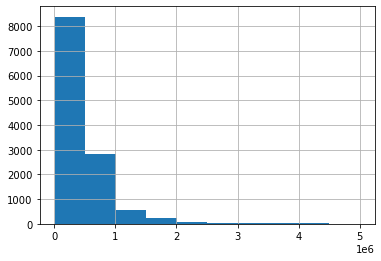

In [30]:
x.tax_value.hist()

<AxesSubplot:>

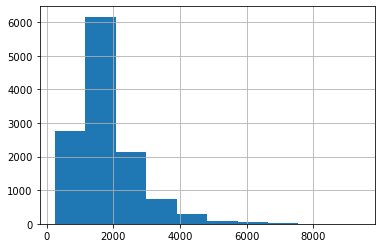

In [31]:
x.square_feet.hist()

## What if we want to handle outliers?
- If we decide we want to exclude properies w/ a taxable value of \$5,000,000 or more..
- Make the original df to be a subset of properties w/ those outliers removed
- then we'll do our 3 splits (train, validate, test)
- make a scaler, fit it on train, then .transform on train, validate, and test


## Where do we go from here?
- Fit our model on scaled data!
- then when we use validate/test datasets to evaluate a model, we'll use the scaled version
- Scale your target variables too!

# Let's use the IQR Rule to handle outliers before scaling

<AxesSubplot:xlabel='tax_value'>

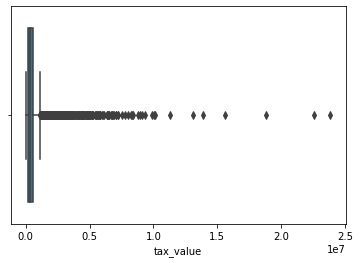

In [32]:
# Let's do a boxplot of tax_value before handling the outliers
sns.boxplot(x="tax_value", data=df)

In [33]:
# Let's handle our outliers using the IQR Rule
train.describe()

,bedrooms,bathrooms,square_feet,tax_value
count,12253.000000,12253.000000,12253.000000,1.225300e+04
mean,3.071738,2.326696,1801.527952,4.987635e+05
std,1.118652,0.993315,936.993352,6.086271e+05
min,0.000000,0.000000,242.000000,1.050400e+04
25%,2.000000,2.000000,1190.000000,2.131000e+05
50%,3.000000,2.000000,1556.000000,3.680000e+05
75%,4.000000,3.000000,2136.000000,5.840000e+05
max,12.000000,10.000000,10656.000000,2.385837e+07


In [34]:
# Let's use IQR for the entire dataset
q1 = df.tax_value.quantile(.25)
q3 = df.tax_value.quantile(.75)
q1, q3

(212788.25, 588463.5)

In [35]:
iqr = q3 - q1
iqr

375675.25

In [36]:
# IQR has a parameter that is a multiplier
# Came out in "EDA" by Tukey
# Tukey uses 1.5 
# Maggie prefers 3

In [37]:
multiplier = 1.5
upper_bound = q3 + (multiplier * iqr)
lower_bound = q1 - (multiplier * iqr)

In [38]:
df.shape

(21882, 4)

In [39]:
lower_bound

-350724.625

In [40]:
# Let's filter out the low outliers
df = df[df.tax_value > lower_bound]
df.shape

(21882, 4)

In [41]:
# Let's filter out the lower value outliers
df = df[df.tax_value < upper_bound]
df.shape

(20450, 4)

<AxesSubplot:xlabel='tax_value'>

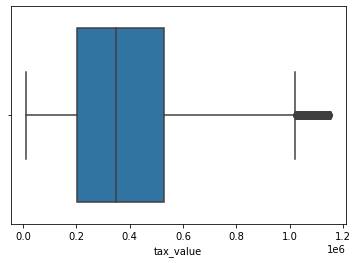

In [42]:
sns.boxplot(x="tax_value", data=df)

In [43]:
train, validate, test = split_data(df, stratify_by="tax_value")

In [44]:
train

,bedrooms,bathrooms,square_feet,tax_value
parcelid,,,,
11973305,3.0,1.0,1416.0,243762.0
14506461,4.0,2.5,2612.0,569334.0
14184209,4.0,3.0,3388.0,801448.0
17191188,2.0,2.0,1021.0,278999.0
11617228,2.0,2.0,1506.0,561560.0
...,...,...,...,...
14402877,0.0,0.0,770.0,284807.0
12753485,3.0,1.0,1000.0,41365.0
11072043,6.0,3.0,2940.0,649759.0
